In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter15-TF"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter15-TF_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(742, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15-tf_dataset.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1,tvt2_2,tvt2_3
0,551099691702956032,rip elly may clampett: so sad to learn #beverl...,True,training,validation,training,training
1,514106273852174337,just in: missing afghan soldiers found trying ...,True,training,training,training,testting
2,495366618818830336,#riphulkhogan my heart is ripping like your sh...,False,training,testting,validation,training
3,532206910796468224,a chick-fil-a manager allegedly banned this hi...,False,validation,training,training,training
4,560187970389819392,islamic tribunal using sharia law in texas has...,False,validation,training,validation,validation


In [4]:
labels_str = data['label'].unique().tolist()
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 1, 1, 1, 1, 0, 1]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(497, 768)
(152, 768)
(93, 768)
(497,)
(152,)
(93,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(649, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(649,)


In [10]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [11]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 2-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 97.495183044316, Validation Accuracy : 100.0, Train Loss : 0.12484360858798027, Validation Loss : 0.005864887032657862
-- Epoch 100, Train_Accuracy : 98.26589595375722, Validation Accuracy : 100.0, Train Loss : 0.07024983502924442, Validation Loss : 0.0046349321492016315
-- Epoch 150, Train_Accuracy : 99.03660886319845, Validation Accuracy : 100.0, Train Loss : 0.04076694534160197, Validation Loss : 0.0028310767374932766
-- Epoch 200, Train_Accuracy : 99.42196531791907, Validation Accuracy : 100.0, Train Loss : 0.024790858529740945, Validation Loss : 0.0020629349164664745
-- Epoch 250, Train_Accuracy : 99.8073217726397, Validation Accuracy : 100.0, Train Loss : 0.013650500623043627, Validation Loss : 0.001060771755874157
-- Epoch 300, Train_Accuracy : 99.8073217726397, Validation Accuracy : 100.0, Train Loss : 0.01006424

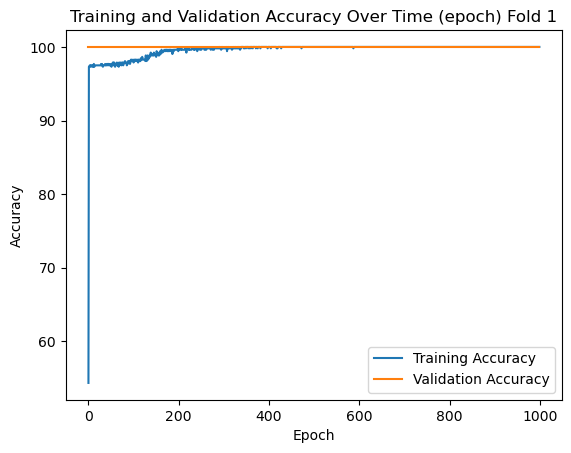

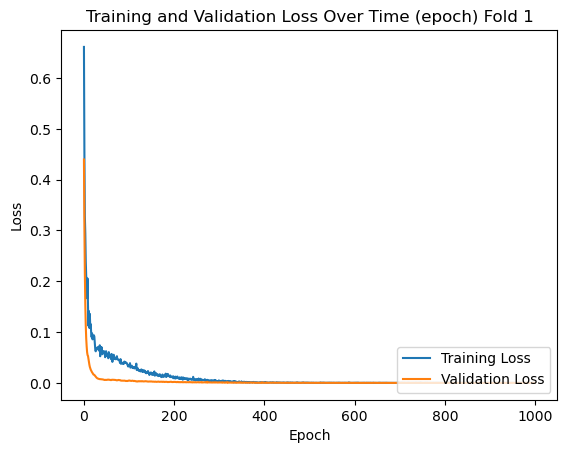

Exec Time : 9.74 seconds
loading model from ../../data/models/cross-validation/Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([519])
Binary Class Evaluation

True Positive : 252
False Positive : 6
False Negative : 7
True Negative : 254

Class False Evaluation
- Precision : 97.674 %
- Recall : 97.297 %
- F1 : 0.97485

Class True Evaluation
- Precision : 97.318 %
- Recall : 97.692 %
- F1 : 0.97505

Combined Evaluation
- Accuracy : 97.495 %
- Precision : 97.496 %
- Recall : 97.495 %
- F1 : 0.97495
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Train, 97.495, 97.496, 97.495, 0.97495, 97.674, 97.297, 0.97485, 97.318, 97.692, 0.97505, 
Confusion Matrix Scikit-learn: 
[[254   6]
 [  7 252]]


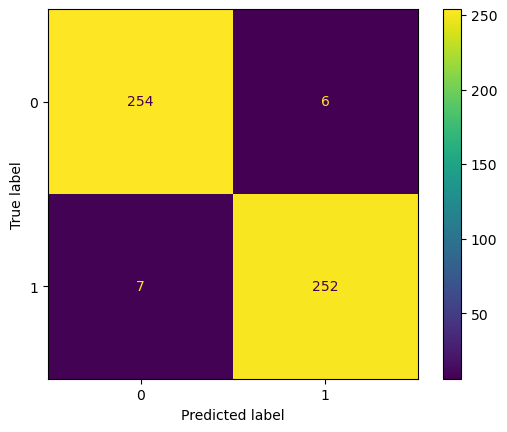


Validation Set
Predictions : torch.Size([130])
Binary Class Evaluation

True Positive : 64
False Positive : 0
False Negative : 0
True Negative : 66

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[66  0]
 [ 0 64]]


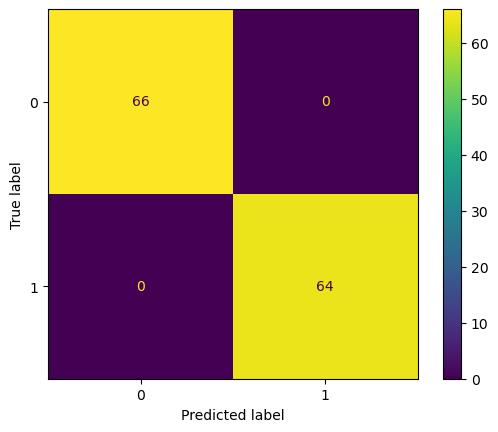


Test Set
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 43
False Positive : 2
False Negative : 4
True Negative : 44

Class False Evaluation
- Precision : 95.556 %
- Recall : 91.489 %
- F1 : 0.93478

Class True Evaluation
- Precision : 91.667 %
- Recall : 95.652 %
- F1 : 0.93617

Combined Evaluation
- Accuracy : 93.548 %
- Precision : 93.611 %
- Recall : 93.571 %
- F1 : 0.93591
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Test, 93.548, 93.611, 93.571, 0.93591, 95.556, 91.489, 0.93478, 91.667, 95.652, 0.93617, 
93
93
Confusion Matrix Scikit-learn: 
[[44  2]
 [ 4 43]]


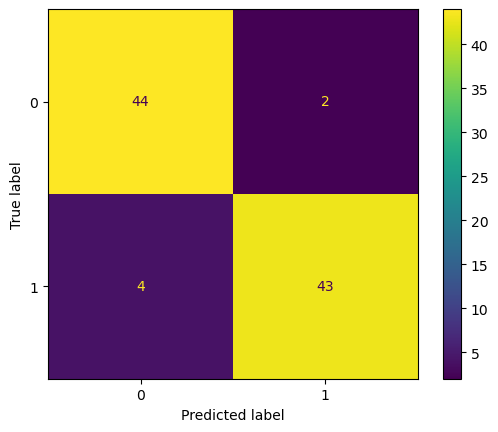

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 97.6878612716763, Validation Accuracy : 100.0, Train Loss : 0.10562414210289717, Validation Loss : 0.0067049115896224976
-- Epoch 100, Train_Accuracy : 98.07321772639692, Validation Accuracy : 100.0, Train Loss : 0.06890861690044403, Validation Loss : 0.004169681575149298
-- Epoch 150, Train_Accuracy : 98.84393063583815, Validation Accuracy : 100.0, Train Loss : 0.041461719898507, Validation Loss : 0.002280336571857333
-- Epoch 200, Train_Accuracy : 99.42196531791907, Validation Accuracy : 100.0, Train Loss : 0.023366122681181878, Validation Loss : 0.002204124815762043
-- Epoch 250, Train_Accuracy : 99.8073217726397, Validation Accuracy : 100.0, Train Loss : 0.011306713277008384, Validation Loss : 0.0017118070973083377
-- Epoch 300, Train_Accuracy : 99.8073217726397, Validation Accuracy : 100.0, Train Loss : 0.007582477992400527, Validation Loss : 0.0029386167880147696
-- Epoch 350, Train_Ac

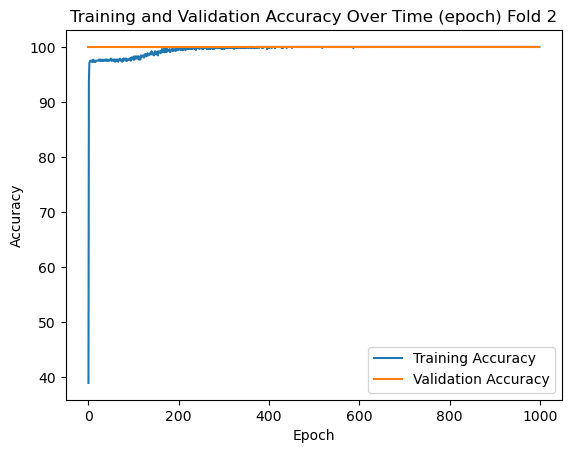

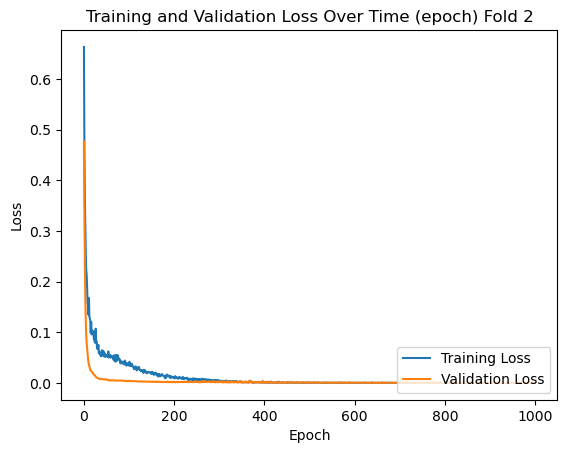

Exec Time : 8.11 seconds
loading model from ../../data/models/cross-validation/Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([519])
Binary Class Evaluation

True Positive : 250
False Positive : 6
False Negative : 8
True Negative : 255

Class False Evaluation
- Precision : 97.656 %
- Recall : 96.899 %
- F1 : 0.97276

Class True Evaluation
- Precision : 96.958 %
- Recall : 97.701 %
- F1 : 0.97328

Combined Evaluation
- Accuracy : 97.303 %
- Precision : 97.307 %
- Recall : 97.3 %
- F1 : 0.97303
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Train, 97.303, 97.307, 97.3, 0.97303, 97.656, 96.899, 0.97276, 96.958, 97.701, 0.97328, 
Confusion Matrix Scikit-learn: 
[[255   6]
 [  8 250]]


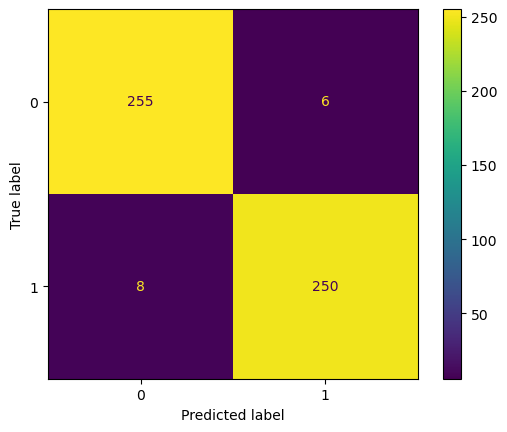


Validation Set
Predictions : torch.Size([130])
Binary Class Evaluation

True Positive : 65
False Positive : 0
False Negative : 0
True Negative : 65

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[65  0]
 [ 0 65]]


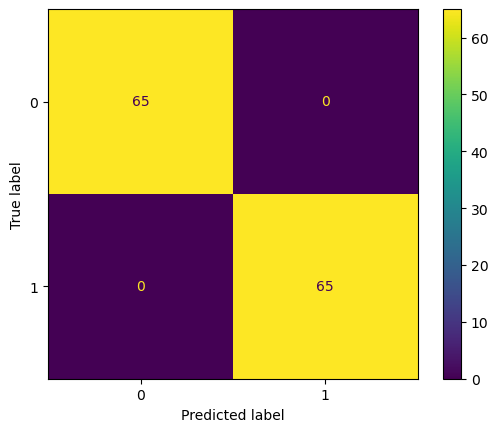


Test Set
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 41
False Positive : 2
False Negative : 6
True Negative : 44

Class False Evaluation
- Precision : 95.349 %
- Recall : 87.234 %
- F1 : 0.91111

Class True Evaluation
- Precision : 88.0 %
- Recall : 95.652 %
- F1 : 0.91667

Combined Evaluation
- Accuracy : 91.398 %
- Precision : 91.674 %
- Recall : 91.443 %
- F1 : 0.91558
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Test, 91.398, 91.674, 91.443, 0.91558, 95.349, 87.234, 0.91111, 88.0, 95.652, 0.91667, 
93
93
Confusion Matrix Scikit-learn: 
[[44  2]
 [ 6 41]]


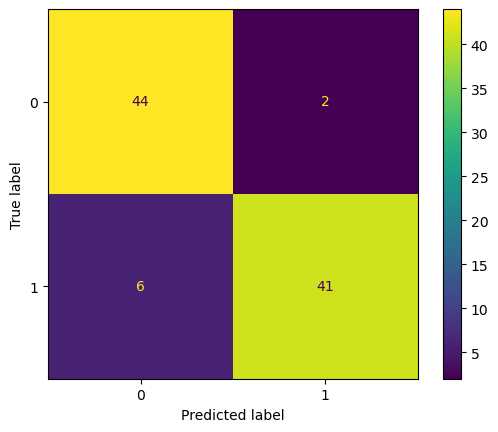

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 97.495183044316, Validation Accuracy : 100.0, Train Loss : 0.11701728776097298, Validation Loss : 0.005679634399712086
-- Epoch 100, Train_Accuracy : 97.88053949903662, Validation Accuracy : 100.0, Train Loss : 0.0720818992704153, Validation Loss : 0.0036474629305303097
-- Epoch 150, Train_Accuracy : 99.42196531791907, Validation Accuracy : 100.0, Train Loss : 0.03325773752294481, Validation Loss : 0.001839548465795815
-- Epoch 200, Train_Accuracy : 99.42196531791907, Validation Accuracy : 100.0, Train Loss : 0.021347867645090446, Validation Loss : 0.0014686051290482283
-- Epoch 250, Train_Accuracy : 99.8073217726397, Validation Accuracy : 100.0, Train Loss : 0.0192913354258053, Validation Loss : 0.0010067563271149993
-- Epoch 300, Train_Accuracy : 99.61464354527938, Validation Accuracy : 100.0, Train Loss : 0.011517399048898369, Validation Loss : 0.0009500544983893633
-- Epoch 350, Train_Ac

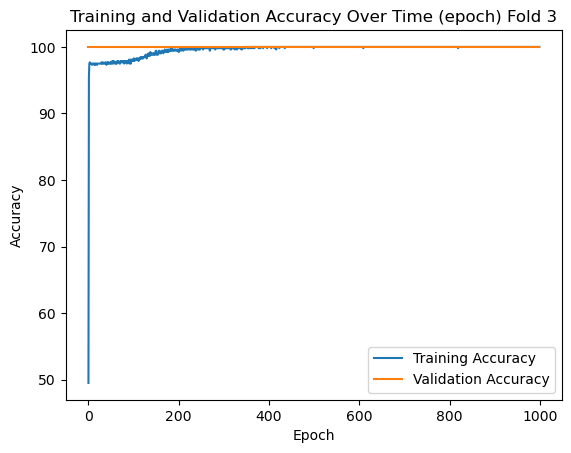

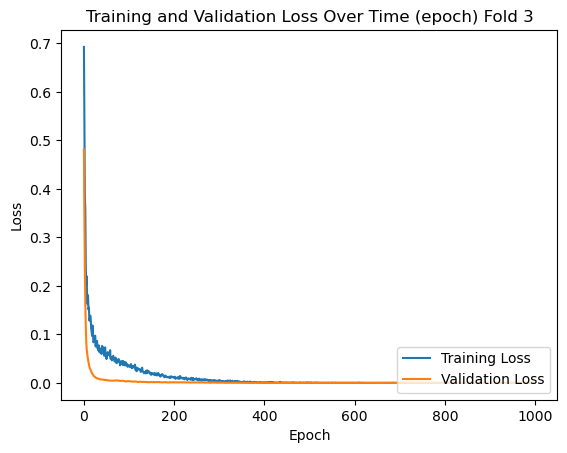

Exec Time : 8.02 seconds
loading model from ../../data/models/cross-validation/Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([519])
Binary Class Evaluation

True Positive : 252
False Positive : 7
False Negative : 6
True Negative : 254

Class False Evaluation
- Precision : 97.297 %
- Recall : 97.674 %
- F1 : 0.97485

Class True Evaluation
- Precision : 97.692 %
- Recall : 97.318 %
- F1 : 0.97505

Combined Evaluation
- Accuracy : 97.495 %
- Precision : 97.495 %
- Recall : 97.496 %
- F1 : 0.97495
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Train, 97.495, 97.495, 97.496, 0.97495, 97.297, 97.674, 0.97485, 97.692, 97.318, 0.97505, 
Confusion Matrix Scikit-learn: 
[[254   7]
 [  6 252]]


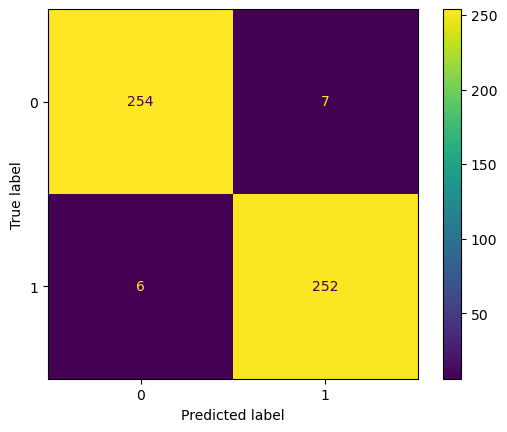


Validation Set
Predictions : torch.Size([130])
Binary Class Evaluation

True Positive : 65
False Positive : 0
False Negative : 0
True Negative : 65

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[65  0]
 [ 0 65]]


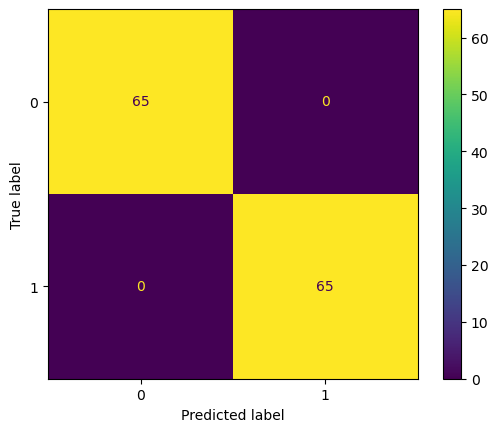


Test Set
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 43
False Positive : 2
False Negative : 4
True Negative : 44

Class False Evaluation
- Precision : 95.556 %
- Recall : 91.489 %
- F1 : 0.93478

Class True Evaluation
- Precision : 91.667 %
- Recall : 95.652 %
- F1 : 0.93617

Combined Evaluation
- Accuracy : 93.548 %
- Precision : 93.611 %
- Recall : 93.571 %
- F1 : 0.93591
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Test, 93.548, 93.611, 93.571, 0.93591, 95.556, 91.489, 0.93478, 91.667, 95.652, 0.93617, 
93
93
Confusion Matrix Scikit-learn: 
[[44  2]
 [ 4 43]]


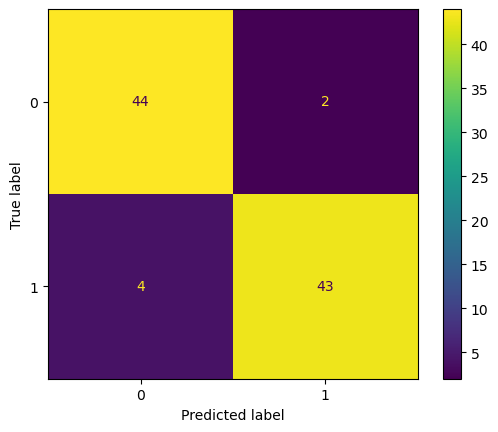

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 96.92307692307692
-- Epoch 50, Train_Accuracy : 98.45857418111753, Validation Accuracy : 96.92307692307692, Train Loss : 0.06933886464685202, Validation Loss : 0.174192875623703
-- Epoch 100, Train_Accuracy : 98.45857418111753, Validation Accuracy : 96.92307692307692, Train Loss : 0.0543978177011013, Validation Loss : 0.16721294820308685
-- Epoch 150, Train_Accuracy : 99.42196531791907, Validation Accuracy : 96.92307692307692, Train Loss : 0.014119099359959364, Validation Loss : 0.17982542514801025
Saving after new best accuracy : 97.6923076923077
-- Epoch 200, Train_Accuracy : 99.8073217726397, Validation Accuracy : 97.6923076923077, Train Loss : 0.006885536829940975, Validation Loss : 0.1981467455625534
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 97.6923076923077, Train Loss : 0.002369652094785124, Validation Loss : 0.2258598804473877
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 97.692307692307

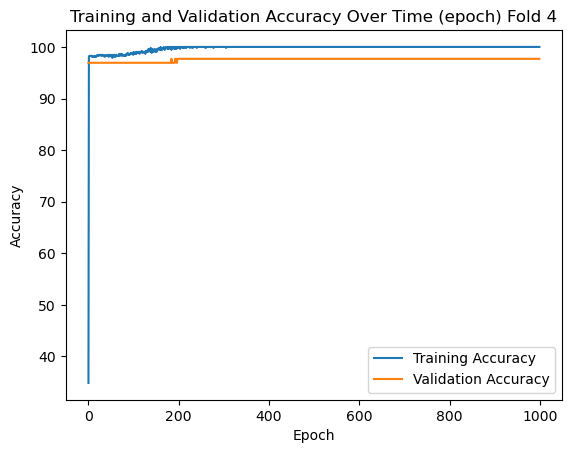

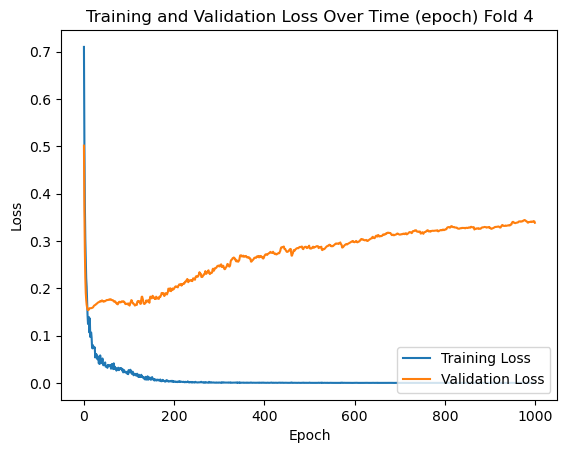

Exec Time : 8.13 seconds
loading model from ../../data/models/cross-validation/Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([519])
Binary Class Evaluation

True Positive : 258
False Positive : 0
False Negative : 0
True Negative : 261

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Train, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[261   0]
 [  0 258]]


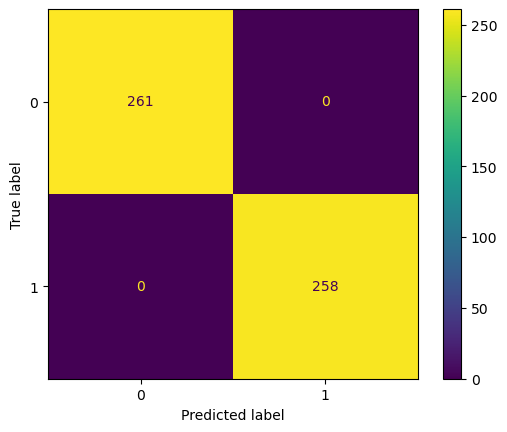


Validation Set
Predictions : torch.Size([130])
Binary Class Evaluation

True Positive : 63
False Positive : 1
False Negative : 2
True Negative : 64

Class False Evaluation
- Precision : 98.438 %
- Recall : 96.923 %
- F1 : 0.97674

Class True Evaluation
- Precision : 96.97 %
- Recall : 98.462 %
- F1 : 0.9771

Combined Evaluation
- Accuracy : 97.692 %
- Precision : 97.704 %
- Recall : 97.692 %
- F1 : 0.97698
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Validation, 97.692, 97.704, 97.692, 0.97698, 98.438, 96.923, 0.97674, 96.97, 98.462, 0.9771, 
Confusion Matrix Scikit-learn: 
[[64  1]
 [ 2 63]]


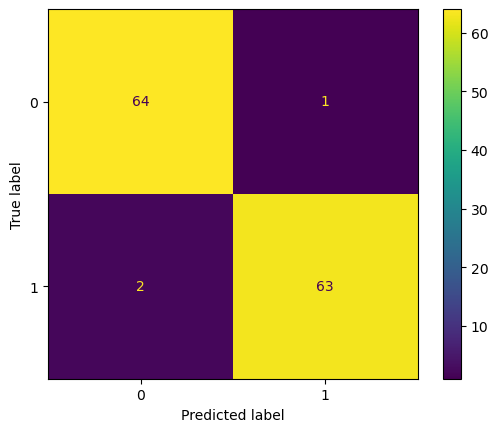


Test Set
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 40
False Positive : 0
False Negative : 7
True Negative : 46

Class False Evaluation
- Precision : 100.0 %
- Recall : 85.106 %
- F1 : 0.91954

Class True Evaluation
- Precision : 86.792 %
- Recall : 100.0 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 92.473 %
- Precision : 93.396 %
- Recall : 92.553 %
- F1 : 0.92973
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Test, 92.473, 93.396, 92.553, 0.92973, 100.0, 85.106, 0.91954, 86.792, 100.0, 0.92929, 
93
93
Confusion Matrix Scikit-learn: 
[[46  0]
 [ 7 40]]


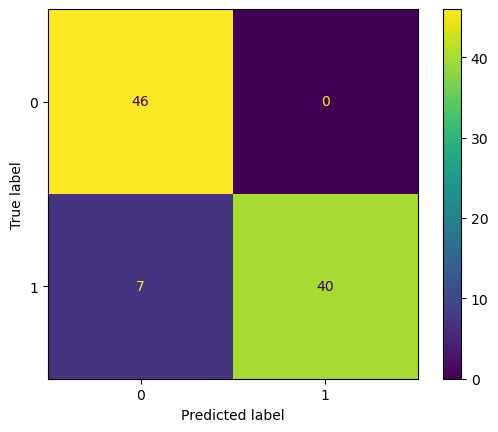

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 93.02325581395348
-- Epoch 50, Train_Accuracy : 99.23076923076923, Validation Accuracy : 93.02325581395348, Train Loss : 0.05022304877638817, Validation Loss : 0.33612778782844543
-- Epoch 100, Train_Accuracy : 99.23076923076923, Validation Accuracy : 92.24806201550388, Train Loss : 0.03573893429711461, Validation Loss : 0.3298433721065521
-- Epoch 150, Train_Accuracy : 99.42307692307692, Validation Accuracy : 90.69767441860465, Train Loss : 0.025951488758437335, Validation Loss : 0.33823665976524353
-- Epoch 200, Train_Accuracy : 99.8076923076923, Validation Accuracy : 88.37209302325581, Train Loss : 0.012764369719661772, Validation Loss : 0.4009721279144287
-- Epoch 250, Train_Accuracy : 99.8076923076923, Validation Accuracy : 89.14728682170542, Train Loss : 0.009121916693402454, Validation Loss : 0.4808460772037506
-- Epoch 300, Train_Accuracy : 99.8076923076923, Validation Accuracy : 89.14728682170542, Train Loss : 0.00673

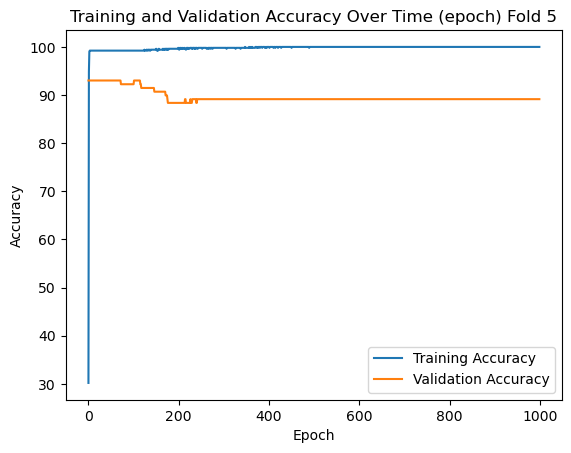

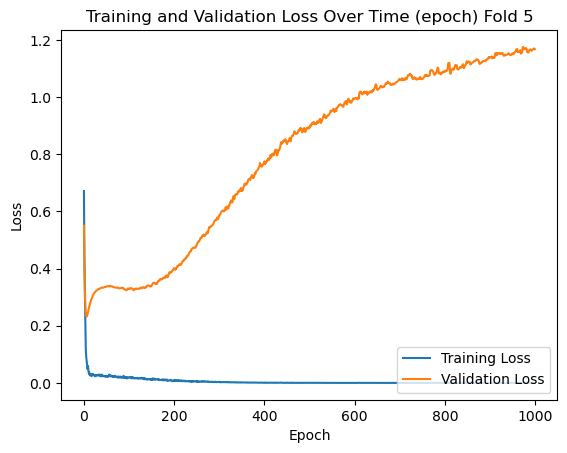

Exec Time : 8.11 seconds
loading model from ../../data/models/cross-validation/Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([520])
Binary Class Evaluation

True Positive : 256
False Positive : 1
False Negative : 3
True Negative : 260

Class False Evaluation
- Precision : 99.611 %
- Recall : 98.842 %
- F1 : 0.99225

Class True Evaluation
- Precision : 98.859 %
- Recall : 99.617 %
- F1 : 0.99237

Combined Evaluation
- Accuracy : 99.231 %
- Precision : 99.235 %
- Recall : 99.229 %
- F1 : 0.99232
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Train, 99.231, 99.235, 99.229, 0.99232, 99.611, 98.842, 0.99225, 98.859, 99.617, 0.99237, 
Confusion Matrix Scikit-learn: 
[[260   1]
 [  3 256]]


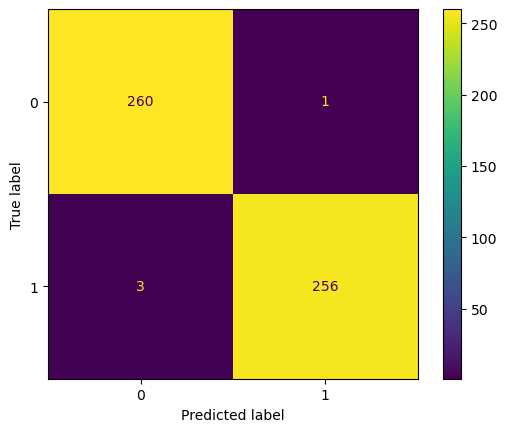


Validation Set
Predictions : torch.Size([129])
Binary Class Evaluation

True Positive : 60
False Positive : 5
False Negative : 4
True Negative : 60

Class False Evaluation
- Precision : 92.308 %
- Recall : 93.75 %
- F1 : 0.93023

Class True Evaluation
- Precision : 93.75 %
- Recall : 92.308 %
- F1 : 0.93023

Combined Evaluation
- Accuracy : 93.023 %
- Precision : 93.029 %
- Recall : 93.029 %
- F1 : 0.93029
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Validation, 93.023, 93.029, 93.029, 0.93029, 92.308, 93.75, 0.93023, 93.75, 92.308, 0.93023, 
Confusion Matrix Scikit-learn: 
[[60  5]
 [ 4 60]]


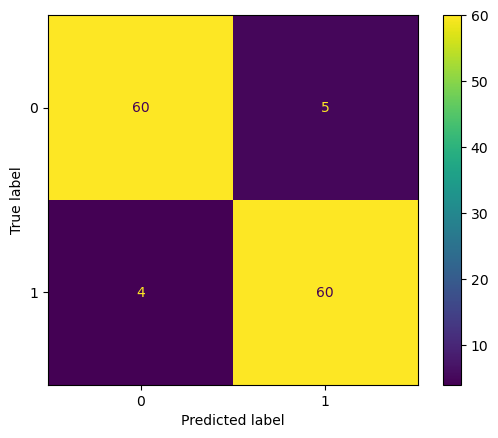


Test Set
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 43
False Positive : 2
False Negative : 4
True Negative : 44

Class False Evaluation
- Precision : 95.556 %
- Recall : 91.489 %
- F1 : 0.93478

Class True Evaluation
- Precision : 91.667 %
- Recall : 95.652 %
- F1 : 0.93617

Combined Evaluation
- Accuracy : 93.548 %
- Precision : 93.611 %
- Recall : 93.571 %
- F1 : 0.93591
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Test, 93.548, 93.611, 93.571, 0.93591, 95.556, 91.489, 0.93478, 91.667, 95.652, 0.93617, 
93
93
Confusion Matrix Scikit-learn: 
[[44  2]
 [ 4 43]]


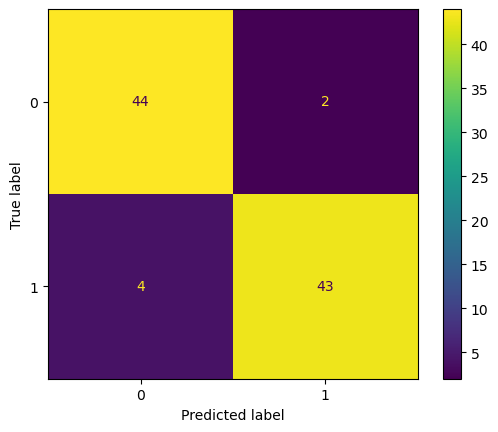

In [12]:
print("Multiclass Classification using 2-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_2LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()